<a href="https://colab.research.google.com/github/PriyanshuRao-code/AI-Lab-Project/blob/main/team_24_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Don't do anything here. It's just a setup.
import os
import sys

repo_name = "AI-Lab-Project"
repo_url = "https://github.com/PriyanshuRao-code/AI-Lab-Project.git"
repo_path = f"/content/{repo_name}"

if os.path.exists(repo_path):
    print("Repository already exists at:", repo_path)
else:
    print("🚀 Cloning the repository...")
    os.system(f"git clone {repo_url}")

os.chdir(repo_path)
sys.path.append(repo_path)

print("Repository is ready to use at:", repo_path)

🚀 Cloning the repository...
Repository is ready to use at: /content/AI-Lab-Project


In [4]:
# Start coding from here.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import random

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('24.csv')

In [7]:
!pip install import-ipynb
import import_ipynb
from team_24_data_preprocessing import data_preprocessing
df_final_train, df_final_valid, df_final_test = data_preprocessing(df)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.2 MB/s eta 0:00:00
Repository already exists at: /content/AI-Lab-Project
Repository is ready to use at: /content/AI-Lab-Project


In [8]:
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
set_seeds(42)

In [9]:
def x_y_separation(df_train, df_valid, df_test, target_column="Hazardous"):
  X_train = df_train.drop(columns=[target_column])
  y_train = df_train[target_column]

  X_valid = df_valid.drop(columns=[target_column])
  y_valid = df_valid[target_column]

  X_test = df_test.drop(columns=[target_column])
  y_test = df_test[target_column]

  return X_train, y_train, X_valid, y_valid, X_test, y_test

In [ ]:
class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)  # Output Layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [13]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_layers):
        super(NeuralNet, self).__init__()
        layers = []
        prev_size = input_size
        for layer_size in hidden_layers:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(nn.Sigmoid())
            prev_size = layer_size
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
def train_model_perceptron(df_train, df_valid, df_test, target_column = "Hazardous", num_epochs=2000, lr=0.0001, seed = 42):

  set_seeds(seed)
  X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)

  X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
  X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
  X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

  y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
  y_valid_tensor = torch.tensor(y_valid.values.reshape(-1, 1), dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)


  perceptron_model = Perceptron(X_train_tensor.shape[1])

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.SGD(perceptron_model.parameters(), lr=lr)

  for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = perceptron_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # if epoch % 10 == 0:
    #   print(f"Epoch {epoch}, Loss: {loss.item()}")

  with torch.no_grad():
    y_valid_pred_nn = perceptron_model(X_valid_tensor).sigmoid().round()
    y_test_pred_nn = perceptron_model(X_test_tensor).sigmoid().round()

    # Convert tensors to numpy
    y_valid_pred_nn = y_valid_pred_nn.detach().numpy()
    y_test_pred_nn = y_test_pred_nn.detach().numpy()

    # Convert y_valid, y_test to numpy for evaluation
    y_valid_numpy = y_valid_tensor.detach().numpy()
    y_test_numpy = y_test_tensor.detach().numpy()

  return perceptron_model, y_valid_numpy, y_test_numpy, y_valid_pred_nn, y_test_pred_nn

In [17]:
from imblearn.over_sampling import SMOTE

def apply_smote(X, y, seed=42):
    sm = SMOTE(random_state=seed)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

In [22]:
from imblearn.over_sampling import RandomOverSampler

def oversample_data(X, y, seed=42):
    ros = RandomOverSampler(random_state=seed)
    X_res, y_res = ros.fit_resample(X, y)
    return X_res, y_res

In [29]:
from imblearn.under_sampling import RandomUnderSampler

def undersample_data(X, y, seed=42):
    rus = RandomUnderSampler(random_state=seed)
    X_res, y_res = rus.fit_resample(X, y)
    return X_res, y_res

In [36]:
def train_model_fcnn(df_train, df_valid, df_test, target_column="Hazardous", num_epochs=2000, lr=0.0001, hidden_layers_list = [[10],[17],[31],[64],[100]],seed=42):
  set_seeds(seed)
  X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)
  X_train, y_train = apply_smote(X_train, y_train)
  #X_train, y_train = oversample_data(X_train, y_train)
  #X_train, y_train = undersample_data(X_train, y_train)

  X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
  X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
  X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

  y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
  y_valid_tensor = torch.tensor(y_valid.values.reshape(-1, 1), dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

  for layer in hidden_layers_list:
    model = NeuralNet(input_size=X_train_tensor.shape[1], hidden_layers=layer)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_history = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

  y_valid_pred = model(X_valid_tensor).detach().numpy()
  y_valid_pred = (y_valid_pred > 0.5).astype(int)
  y_valid_numpy = y_valid_tensor.numpy()

  y_test_pred = model(X_test_tensor).detach().numpy()
  y_test_pred = (y_test_pred > 0.5).astype(int)
  y_test_numpy = y_test_tensor.numpy()

  return model, y_valid_numpy, y_test_numpy, y_valid_pred, y_test_pred

In [ ]:
def train_model_gaussian(df_train, df_valid, df_test, target_column="Hazardous"):

  X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)

  X_train_nb = np.array(X_train)
  X_valid_nb = np.array(X_valid)
  X_test_nb = np.array(X_test)

  y_train_nb = np.array(y_train)
  y_valid_nb = np.array(y_valid)
  y_test_nb = np.array(y_test)

  naiveBayes = GaussianNB()
  naiveBayes.fit(X_train_nb, y_train_nb)

  y_valid_pred_nb = naiveBayes.predict(X_valid_nb)
  y_test_pred_nb = naiveBayes.predict(X_test_nb)

  return naiveBayes, y_valid_nb, y_test_nb, y_valid_pred_nb, y_test_pred_nb

In [ ]:
def mahalanobis_distance(x, mean, inv_cov_matrix):
    diff = x - mean
    mahal_dist = np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))
    return mahal_dist

In [ ]:
def knn_mahalanobis(X_train, y_train, X_test, K):
    # mean_vector = np.mean(X_train, axis=0)  # Compute mean of training data
    cov_matrix = np.cov(X_train.T)
    inv_cov_matrix = np.linalg.pinv(cov_matrix)  # Compute pseudo-inverse for stability
    y_pred = []

    for x in X_test:
        distances = [mahalanobis_distance(x, X_train[i], inv_cov_matrix) for i in range(len(X_train))]
        k_nearest_indices = np.argsort(distances)[:K]
        k_nearest_labels = y_train[k_nearest_indices]
        most_common_label = Counter(k_nearest_labels).most_common(1)[0][0]
        y_pred.append(most_common_label)

    return np.array(y_pred)

In [ ]:
def train_model_knn(df_train, df_valid, df_test, target_column="Hazardous", k_values = [1, 3]):

  X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)

  X_train_knn = np.array(X_train)
  X_valid_knn = np.array(X_valid)
  X_test_knn = np.array(X_test)

  y_train_knn = np.array(y_train)
  y_valid_knn = np.array(y_valid)
  y_test_knn = np.array(y_test)

  accuracies = []
  for k in k_values:
    y_valid_pred = knn_mahalanobis(X_train_knn, y_train_knn, X_valid_knn, k)
    acc = accuracy_score(y_valid_knn, y_valid_pred)
    accuracies.append(acc)

  # Find the best K
  best_k = k_values[np.argmax(accuracies)]

  mean_vector = np.mean(X_train_knn, axis=0)
  cov_matrix = np.cov(X_train_knn.T)
  inv_cov_matrix = np.linalg.pinv(cov_matrix)
  knn_final = KNeighborsClassifier(n_neighbors=best_k, metric="mahalanobis", metric_params={"VI": inv_cov_matrix})
  knn_final.fit(X_train_knn, y_train_knn)

  y_valid_pred_knn = knn_final.predict(X_valid_knn)
  y_test_pred_knn = knn_final.predict(X_test_knn)

  return knn_final, y_valid_knn, y_test_knn, y_valid_pred_knn, y_test_pred_knn

In [ ]:
def train_model_logistic(df_train, df_valid, df_test, target_column="Hazardous", solver='sag',max_iter=2000):

  X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)
  logistic_reg = LogisticRegression(solver=solver, max_iter = max_iter)
  logistic_reg.fit(X_train,y_train)
  y_val_pred = logistic_reg.predict(X_valid)
  y_test_pred = logistic_reg.predict(X_test)

  return logistic_reg, y_valid, y_test, y_val_pred, y_test_pred

In [ ]:
def train_model_svc(df_train, df_valid, df_test, target_column="Hazardous"):

  X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)

  model = SVC(kernel='linear', C=1.0)
  model.fit(X_train, y_train)
  y_test_pred = model.predict(X_test)
  y_val_pred = model.predict(X_valid)

  return model, y_valid, y_test, y_val_pred, y_test_pred

In [ ]:
def train_model_svc_rbf(df_train, df_valid, df_test, target_column="Hazardous"):
  X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)

  model = SVC(kernel='rbf', C=5.0, gamma='scale')
  model.fit(X_train, y_train)
  y_test_pred = model.predict(X_test)
  y_val_pred = model.predict(X_valid)

  return model, y_valid, y_test, y_val_pred, y_test_pred

In [ ]:
def train_model_svc_poly(df_train, df_valid, df_test, target_column="Hazardous"):
  X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)
  model = SVC(kernel='poly', degree=3, C=8.0, gamma='scale')
  model.fit(X_train, y_train)
  y_test_pred = model.predict(X_test)
  y_val_pred = model.predict(X_valid)

  return model, y_valid, y_test, y_val_pred, y_test_pred

In [ ]:
def train_model_random_forest(df_train, df_valid, df_test, target_column="Hazardous", n_estimators=100, random_state=42):

    X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)

    X_train_rf = np.array(X_train)
    X_valid_rf = np.array(X_valid)
    X_test_rf = np.array(X_test)

    y_train_rf = np.array(y_train)
    y_valid_rf = np.array(y_valid)
    y_test_rf = np.array(y_test)

    random_forest = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    random_forest.fit(X_train_rf, y_train_rf)

    y_valid_pred_rf = random_forest.predict(X_valid_rf)
    y_test_pred_rf = random_forest.predict(X_test_rf)

    return random_forest, y_valid_rf, y_test_rf, y_valid_pred_rf, y_test_pred_rf

In [15]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    print(f"\nEvaluation Metrics for {model_name}:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=["Not Hazardous", "Hazardous"], yticklabels=["Not Hazardous", "Hazardous"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")

    return accuracy, precision, recall, f1


Evaluation Metrics for FCNN using SMOTE (Validation):


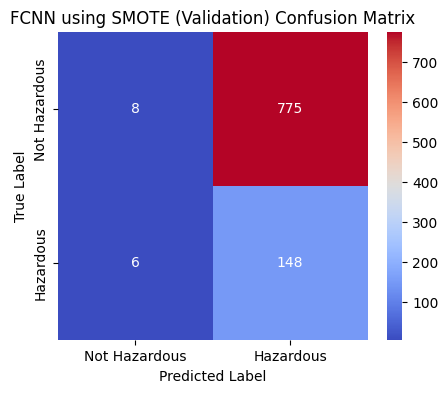


  Accuracy:  0.1665
  Precision: 0.1603
  Recall:    0.9610
  F1-score:  0.2748

Evaluation Metrics for FCNN using SMOTE (Test):


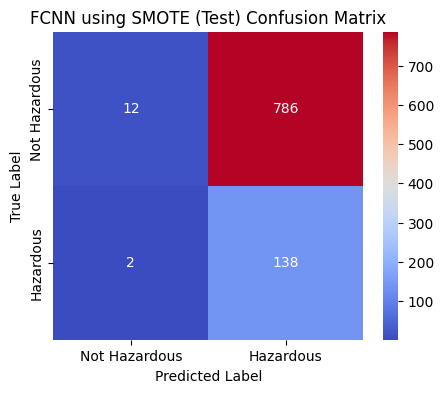


  Accuracy:  0.1599
  Precision: 0.1494
  Recall:    0.9857
  F1-score:  0.2594


(0.15991471215351813,
 0.14935064935064934,
 0.9857142857142858,
 0.2593984962406015)

In [37]:
# _, y_valid_numpy, y_test_numpy, y_valid_pred_nn, y_test_pred_nn = train_model_fcnn(df_final_train, df_final_valid, df_final_test)

# evaluate_model(y_valid_numpy, y_valid_pred_nn, "FCNN using SMOTE (Validation)")
# evaluate_model(y_test_numpy, y_test_pred_nn, "FCNN using SMOTE (Test)")


# _, y_valid_nb, y_test_nb, y_valid_pred_nb, y_test_pred_nb = train_model_gaussian(df_final_train, df_final_valid, df_final_test)

# evaluate_model(y_valid_nb, y_valid_pred_nb, "Naïve Bayes (Validation)")
# evaluate_model(y_test_nb, y_test_pred_nb, "Naïve Bayes (Test)")


# _, y_valid_knn, y_test_knn, y_valid_pred_knn, y_test_pred_knn = train_model_knn(df_final_train, df_final_valid, df_final_test)
# evaluate_model(y_valid_knn, y_valid_pred_knn, "KNN with Mahalanobis (Validation)")
# evaluate_model(y_test_knn, y_test_pred_knn, "KNN with Mahalanobis (Test)")

# _, y_valid_logistic, y_test_logistic, y_valid_pred_logistic, y_test_pred_logistic = train_model_logistic(df_final_train, df_final_valid, df_final_test)
# evaluate_model(y_valid_logistic, y_valid_pred_logistic, "Logistic Regression (Validation)")
# evaluate_model(y_test_logistic, y_test_pred_logistic, "Logistic Regression (Test)")

# _, y_valid_svc, y_test_svc, y_valid_pred_svc, y_test_pred_svc = train_model_svc(df_final_train, df_final_valid, df_final_test)
# evaluate_model(y_valid_svc, y_valid_pred_svc, "Support Vector Machine (Validation)")
# evaluate_model(y_test_svc, y_test_pred_svc, "Support Vector Machine (Test)")


# **KNN analysis for k-values**

In [ ]:
# X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_final_train, df_final_valid, df_final_test)

# X_train_knn = np.array(X_train)
# X_valid_knn = np.array(X_valid)
# X_test_knn = np.array(X_test)

# y_train_knn = np.array(y_train)
# y_valid_knn = np.array(y_valid)
# y_test_knn = np.array(y_test)

# accuracies = []
# k_values = [1, 3, 5, 7, 11]
# for k in k_values:
#     y_valid_pred = knn_mahalanobis(X_train_knn, y_train_knn, X_valid_knn, k)
#     acc = accuracy_score(y_valid_knn, y_valid_pred)
#     accuracies.append(acc)

#   # Find the best K
# best_k = k_values[np.argmax(accuracies)]

# mean_vector = np.mean(X_train_knn, axis=0)
# cov_matrix = np.cov(X_train_knn.T)
# inv_cov_matrix = np.linalg.pinv(cov_matrix)
# knn_final = KNeighborsClassifier(n_neighbors=best_k, metric="mahalanobis", metric_params={"VI": inv_cov_matrix})
# knn_final.fit(X_train_knn, y_train_knn)


# plt.figure(figsize=(10, 5))
# plt.plot(k_values, accuracies, marker='o', linestyle='-', color='blue', label="Validation Accuracy")
# plt.axvline(x=best_k, color='red', linestyle='--', label="Best K")
# plt.xlabel("Number of Neighbors (K)")
# plt.ylabel("Validation Accuracy")
# plt.title("KNN with Mahalanobis: Accuracy vs K")
# plt.legend()
# plt.grid()
# plt.show()